In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.io_utils import HDF5Matrix

# base_path = os.path.join('', 'input')
#选取的是灰度图像
train_h5_path = os.path.join(
#     base_path, 
    'food_c101_n10099_r64x64x1.h5')
test_h5_path = os.path.join(
#     base_path, 
    'food_test_c101_n1000_r64x64x1.h5')
%matplotlib inline

Using TensorFlow backend.


### 训练集集分析
* 一共101分类
* 一共10099张图片

In [2]:
# data_type: <class 'keras.utils.io_utils.HDF5Matrix'>
# 也可以进行切片操作，在下面的函数参数列表中加,start=0, end=None
x_train = HDF5Matrix(train_h5_path, 'images')
y_train = HDF5Matrix(train_h5_path, 'category')
print('In Data',x_train.shape,'=>', y_train.shape)
print('data_type:',type(x_train))

In Data (10099, 64, 64, 1) => (10099, 101)
data_type: <class 'keras.utils.io_utils.HDF5Matrix'>


In [6]:
print(len(x_train))

10099


In [3]:
# 测试集而不是验证集 也是由专门的标签
# X_test = np.array(HDF5Matrix(test_h5_path, 'images',start=0, end=200))
# y_test = np.array(HDF5Matrix(test_h5_path, 'images',start=0, end=200))
x_test = HDF5Matrix(test_h5_path, 'images',start=0, end=50)
y_test = HDF5Matrix(test_h5_path, 'category',start=0, end=50)
print('In Data',x_test.shape,'=>', y_test.shape)
print()

In Data (50, 64, 64, 1) => (50, 101)



### 可视化

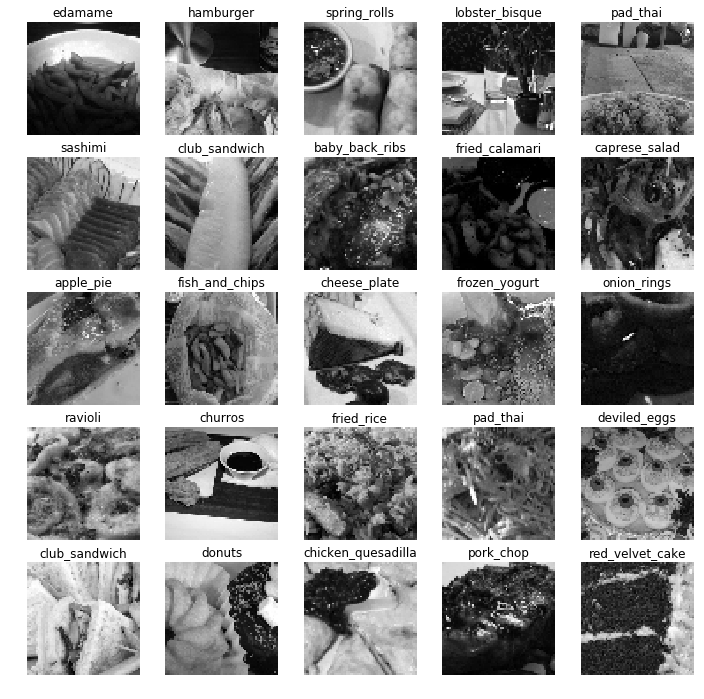

In [10]:
sample_imgs = 25
with h5py.File(train_h5_path, 'r') as n_file:
    total_imgs = n_file['images'].shape[0]
    read_idxs = slice(0,sample_imgs)
    im_data = n_file['images'][read_idxs]
    im_label = n_file['category'].value[read_idxs]
    label_names = [x.decode() for x in n_file['category_names'].value]
fig, m_ax = plt.subplots(5, 5, figsize = (12, 12))
for c_ax, c_label, c_img in zip(m_ax.flatten(), im_label, im_data):
    c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_title(label_names[np.argmax(c_label)])

### labels_to_onehot

In [ ]:
# 好像本来就是onehot。。。
# import pandas as pd
# y_train_oh = pd.get_dummies(y_train)
# y_test_oh = pd.get_dummies(y_test)

## 搭建神经网络
### 一
* 先研究数据集怎么输出
* 标签匹配到图片
* 训练集中分一部分有正确标签的来测试模型精准度
* test：用于验证模型 让其输出直接的图片类型

### 二
* 要不要用到VGG的参数？


In [4]:
# 参数
batch_size = 50  # 一批取50个数据
lr = 0.9         # learning rate

In [5]:
import tensorflow as tf

# 创建模型
tf_x = tf.placeholder(tf.float32,[None,64,64,1])
# x_img = tf.reshape(tf_x,[-1,64,64,1])
tf_y = tf.placeholder(tf.float32,[None,101])

## CNN
conv1 = tf.layers.conv2d(           # shape:(64,64,1)
#         inputs = x_img,
        inputs = tf_x,
        filters = 10,               # 图像卷积后的深度
        kernel_size = 5,            # 扫描核5*5大小
        padding = 'same',
        activity_regularizer = tf.nn.relu
)                                   # shape:(64,64,10)
pool1 = tf.layers.max_pooling2d(
        inputs = conv1,
        pool_size = [2,2],
        strides = 2
)                                   # shape:(32,32,10)
conv2 = tf.layers.conv2d(
        inputs = pool1,
        filters = 20,
        kernel_size = 5,
        padding = 'same',
        activity_regularizer = tf.nn.relu
)                                   # shape:(32,32,20)
pool2 = tf.layers.max_pooling2d(
        inputs = conv2,
        pool_size = [2,2],
        strides = 2
)                                   # shape:(16,16,20)
conv3 = tf.layers.conv2d(
        inputs = pool2,
        filters = 40,
        kernel_size = 5,
        padding = 'same',
        activity_regularizer = tf.nn.relu
)                                   # shape:(16，16，40)
pool3 = tf.layers.max_pooling2d(
        inputs = conv3,
        pool_size = [2,2],
        strides = 2
)                                   # shape:(8，8，40)
shape = pool3.get_shape().as_list() # (ง •_•)ง
flat_data = tf.reshape(pool3,[-1,shape[1]*shape[2]*shape[3]])
output = tf.layers.dense(flat_data,101) #用于全连接层

In [6]:
loss = tf.losses.mean_squared_error(
    labels = tf_y,
    predictions = output
)

In [7]:
train_op = tf.train.AdamOptimizer(lr).minimize(loss)

In [8]:
# 用于测试该模型的识别精确度
accuracy = tf.metrics.accuracy(
        labels = tf.argmax(tf_y,axis = 1),
        predictions = tf.argmax(output,axis = 1)
)[1]

In [9]:
sess = tf.Session()
# 初始化全局和本地变量
init_op = tf.group(
        tf.global_variables_initializer(), 
        tf.local_variables_initializer())
sess.run(init_op)

In [10]:
# 训练
for step in range(501):
    p = (step*batch_size)%10000
    q = ((step+1)*batch_size)%10000
    if p>q:
        q = 10099

    b_x = x_train[p:q]
    b_y = y_train[p:q]
    sess.run(train_op,{tf_x:b_x,tf_y:b_y})
    if step % 50 ==0:
#         acc_, loss_ = sess.run([accuracy, loss], {tf_x:x_test,tf_y:y_test})
#         print("Step: %i" % step, "| Accurate: %.8f" % acc_, "| Loss: %.2f" % loss_ )
        # 不计算loss版
        acc_= sess.run(accuracy, {tf_x:x_test,tf_y:y_test})
        print("Step: %i" % step, "| Accurate: %.8f" % acc_)

    # 检验一下是否输出正常
    if step == 500:
        predictions_2 = tf.argmax(output,axis = 1)
        labels2 = tf.argmax(tf_y,axis = 1)
        acc_,predictions_2_ ,output_,labels2_= sess.run([accuracy,predictions_2,output,labels2], feed_dict = {tf_x:x_test[0:20],tf_y:y_test[0:20]})
        print('predictions_2:', predictions_2_,'output:',output_)
        print('accuracy:',acc_)
        print('labels2_:',labels2_)

Step: 0 | Accurate: 0.00000000
Step: 50 | Accurate: 0.00000000
Step: 100 | Accurate: 0.00000000
Step: 150 | Accurate: 0.00000000
Step: 200 | Accurate: 0.00000000
Step: 250 | Accurate: 0.00000000
Step: 300 | Accurate: 0.00000000


KeyboardInterrupt: 

In [34]:
print('labels2_:',labels2_)

labels2_: [94 66 39 12 74  6 26  5 38 94  5 95 31 16 70 65 73 18 34  5]
